In [45]:
import torch

In [46]:
from torch.utils.data import Dataset, DataLoader

In [47]:
import tiktoken

In [48]:
# 将文本转化为token_id并以tensor形式存储
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []
        token_ids = tokenizer.encode(txt)
        
        for i in range(0, len(token_ids) - max_length, stride):  # 建立对应的输入和输出toekn_id tensor
            input_chunk = token_ids[i: i+ max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
            
    def __len__(self):
        return len(self.input_ids)  # 判断长度
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]  # 返回输入和目标tensor中某一行

In [49]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.encoding_for_model("gpt-4")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride) 
    dataloader = DataLoader(
                            dataset,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            drop_last=drop_last, 
                            num_workers=num_workers 
    )
    return dataloader

In [50]:
tokenizer_bpe = tiktoken.encoding_for_model("gpt-4")

In [51]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

In [52]:
vocab_size = 50257
output_dim = 256

# 创建嵌入层，vocab_size表示一次处理几个值，output_dim表示每个值变为几维向量
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

# 将文字数据变为token id
max_length = 4
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=max_length, stride=max_length, shuffle=False)

In [53]:
dataiter = iter(dataloader)
input_ids, target_ids = next(dataiter)
print("input: ", input_ids)
print("target: ", target_ids)

input:  tensor([[   40,   473,  1846,  2744],
        [ 3463,  7762,   480,   285],
        [22464,  4856,   264, 12136],
        [35201,   313,  4636,   264],
        [ 1695, 12637,  3403,   313],
        [  708,   433,   574,   912],
        [ 2294, 13051,   311,   757],
        [  311,  6865,   430,    11]])
target:  tensor([[  473,  1846,  2744,  3463],
        [ 7762,   480,   285, 22464],
        [ 4856,   264, 12136, 35201],
        [  313,  4636,   264,  1695],
        [12637,  3403,   313,   708],
        [  433,   574,   912,  2294],
        [13051,   311,   757,   311],
        [ 6865,   430,    11,   304]])


In [54]:
# 对每个token id进行向量嵌入，此时每个token id变为256维
token_vector = token_embedding_layer(input_ids)
print(token_vector)

tensor([[[-0.0640,  0.3317,  0.1070,  ...,  0.5349, -0.8024, -2.3238],
         [-2.6152,  1.8968, -2.0278,  ..., -0.9420,  0.3943,  0.6963],
         [-0.4542,  0.0804,  0.2498,  ...,  2.8720,  0.8886, -0.7654],
         [ 0.4551,  0.7934,  0.4339,  ..., -0.8529, -1.6315,  0.0425]],

        [[-0.1158, -0.0547,  1.0704,  ..., -1.2570, -0.6866, -1.6936],
         [-0.3795, -0.2749,  0.7593,  ...,  0.1062, -0.3005,  1.0571],
         [-0.8287,  1.6981, -0.3909,  ..., -1.7100,  1.3018, -1.0101],
         [ 1.0111, -0.0495,  2.4740,  ..., -0.3767, -0.1712, -0.2918]],

        [[ 0.8354, -0.4926, -0.0470,  ...,  2.4018, -0.3425,  0.5318],
         [-0.7248,  0.8782, -0.1657,  ..., -0.5799, -0.9146,  0.1777],
         [ 0.1425,  0.4516, -1.3591,  ..., -0.2467,  1.3578, -0.7550],
         [ 0.1018, -1.8138, -2.1062,  ...,  0.7594, -0.7817, -1.4979]],

        ...,

        [[-1.0516,  1.9677,  0.9734,  ...,  2.0354, -1.1147, -1.0602],
         [ 1.1154, -0.7639, -2.5322,  ...,  0.9054,  0.79

In [55]:
# 考虑相对位置，使用递增序列建立嵌入向量，并分与token id变为的嵌入向量进行加和，由于广播机制，位置向量会分别和每一行token id变为的向量加和
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)
pos_embedding = pos_embedding_layer(torch.arange(context_length))
print(pos_embedding)

tensor([[-1.4150, -0.3142,  0.2827,  ...,  0.8155, -0.1085, -1.1927],
        [-1.9800,  0.0610, -0.0494,  ..., -0.6422,  0.5716, -1.1329],
        [ 1.0052,  1.7802,  1.2652,  ..., -1.1619, -0.1109,  1.0411],
        [ 0.3760, -0.3758, -0.0484,  ...,  0.1080,  0.3852,  1.0876]],
       grad_fn=<EmbeddingBackward0>)


In [56]:
input_embeddings = token_vector + pos_embedding
print(input_embeddings)

tensor([[[-1.4789,  0.0176,  0.3897,  ...,  1.3504, -0.9109, -3.5165],
         [-4.5951,  1.9578, -2.0772,  ..., -1.5843,  0.9660, -0.4365],
         [ 0.5511,  1.8607,  1.5150,  ...,  1.7102,  0.7776,  0.2757],
         [ 0.8312,  0.4176,  0.3856,  ..., -0.7449, -1.2463,  1.1301]],

        [[-1.5307, -0.3689,  1.3532,  ..., -0.4415, -0.7951, -2.8863],
         [-2.3594, -0.2139,  0.7098,  ..., -0.5360,  0.2711, -0.0757],
         [ 0.1765,  3.4784,  0.8743,  ..., -2.8719,  1.1909,  0.0309],
         [ 1.3871, -0.4253,  2.4257,  ..., -0.2686,  0.2140,  0.7959]],

        [[-0.5796, -0.8068,  0.2357,  ...,  3.2173, -0.4510, -0.6608],
         [-2.7048,  0.9392, -0.2151,  ..., -1.2221, -0.3430, -0.9551],
         [ 1.1477,  2.2318, -0.0939,  ..., -1.4085,  1.2469,  0.2860],
         [ 0.4779, -2.1896, -2.1546,  ...,  0.8674, -0.3965, -0.4103]],

        ...,

        [[-2.4665,  1.6535,  1.2561,  ...,  2.8509, -1.2232, -2.2529],
         [-0.8646, -0.7029, -2.5816,  ...,  0.2632,  1.36

### 3.3 Attending to different parts of the input with self-attention

#### 3.3.1 A simple self-attention mechanism without trainable weights

In [57]:
inputs = torch.tensor(
 [[0.43, 0.15, 0.89], # Your (x^1)
 [0.55, 0.87, 0.66], # journey (x^2)
 [0.57, 0.85, 0.64], # starts (x^3)
 [0.22, 0.58, 0.33], # with (x^4)
 [0.77, 0.25, 0.10], # one (x^5)
 [0.05, 0.80, 0.55]] # step (x^6)
)

In [58]:
# 对第二个向量计算注意力权重
query = inputs[1]
attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(query, x_i)
print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


In [59]:
# 进行归一化（按比例）
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()
print(attn_weights_2_tmp)

tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])


In [60]:
attn_weights_2_tmp.sum()

tensor(1.0000)

In [61]:
# 简单softmax归一化
def softmax_naive(x):
    result = torch.exp(x) / torch.exp(x).sum()
    return result

In [62]:
attn_weights_2_naive = softmax_naive(attn_scores_2)
print(attn_weights_2_naive)

tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])


In [63]:
attn_weights_2_naive.sum()

tensor(1.)

In [64]:
# 使用pytorch的softmax函数进行归一化
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)
print(attn_weights_2, attn_weights_2.sum())

tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581]) tensor(1.)


In [65]:
# context vector
context_vec_2 = torch.zeros(query.shape)
for i, x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i] * x_i

In [66]:
context_vec_2

tensor([0.4419, 0.6515, 0.5683])

In [67]:
# 计算所有inputs的context vector
def context_vec_cal_v1(inputs):
    attn_weights_all = torch.zeros([inputs.shape[0], inputs.shape[0]])
    for i in range(len(inputs)):
        for j in range(len(inputs)):
            attn_weights_all[i][j] += inputs[i].dot(inputs[j])
    attn_weights_norm = torch.softmax(attn_weights_all, dim=1)
    
#     return attn_weights_norm
    
    context_vec_all = torch.zeros(inputs.shape)
    for i in range(len(inputs)):
        for j in range(len(inputs)):
            context_vec_all[i] +=  attn_weights_norm[i][j] * inputs[j]
    return context_vec_all

In [68]:
context_vec_cal_v1(inputs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])

In [69]:
import torch.nn.functional as F

def context_vec_cal_v2(inputs):
    # inputs: [seq_len, dim]
    
    # 计算注意力权重矩阵：[seq_len, seq_len]
    attn_weights_all = inputs @ inputs.T  # 等价于 dot product，矩阵乘法自动计算所有两两 dot

    # 对每一行 softmax，表示每个 token 对所有 token 的注意力
    attn_weights_norm = F.softmax(attn_weights_all, dim=1)

    # 计算 context vector（即加权求和）：[seq_len, dim]
    context_vec_all = attn_weights_norm @ inputs  # 每一行是当前 token 的 context 向量

    return context_vec_all

In [70]:
context_vec_cal_v2(inputs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])

In [71]:
inputs

tensor([[0.4300, 0.1500, 0.8900],
        [0.5500, 0.8700, 0.6600],
        [0.5700, 0.8500, 0.6400],
        [0.2200, 0.5800, 0.3300],
        [0.7700, 0.2500, 0.1000],
        [0.0500, 0.8000, 0.5500]])

In [72]:
attn_score = inputs @ inputs.T
attn_score

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])

In [73]:
attn_weights = torch.softmax(attn_score, dim=-1)
attn_weights

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])

In [74]:
attn_weights[0].sum()

tensor(1.0000)

In [75]:
attn_weights.sum(dim=-1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

In [76]:
attn_context_vecs = attn_weights @ inputs
attn_context_vecs

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])

### 3.4 Implementing self-attention with trainable weights

#### 3.4.1 Computing the attention weights step by step

In [77]:
# 仅计算x2的三个向量
x2 = inputs[1]
d_in = inputs.shape[1]
d_out = 2

In [78]:
torch.manual_seed(123)

In [79]:
W_q = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_k = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_v = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

In [80]:
query_2 = x2 @ W_q
key_2 = x2 @ W_k
value_2 = x2 @ W_v
print(query_2)

tensor([0.4306, 1.4551])


In [81]:
# 计算所有输入的三个向量
query = inputs @ W_q
key = inputs @ W_k
value = inputs @ W_v
print(query)

tensor([[0.2309, 1.0966],
        [0.4306, 1.4551],
        [0.4300, 1.4343],
        [0.2355, 0.7990],
        [0.2983, 0.6565],
        [0.2568, 1.0533]])


In [82]:
# 计算x2的注意力分数
key_2 = key[1]
attn_score_22 = query_2.dot(key_2)
print(attn_score_22)

tensor(1.8524)


In [83]:
attn_score_2 = query_2 @ key.T
print(attn_score_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


In [84]:
d_k = key.shape[-1]
attn_weight_2 = torch.softmax(attn_score_2 / d_k ** 0.5, dim=-1)
print(attn_weight_2)

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


In [85]:
context_vec_2 = attn_weight_2 @ value
print(context_vec_2)

tensor([0.3061, 0.8210])


##### 3.4.2 Implementing a compact self-attention Python class

In [86]:
class selfAttention_v1(torch.nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_q = torch.nn.Parameter(torch.rand(d_in, d_out))
        self.W_k = torch.nn.Parameter(torch.rand(d_in, d_out))
        self.W_v = torch.nn.Parameter(torch.rand(d_in, d_out))
    
    def forward(self, x):
        query = x @ self.W_q
        key = x @ self.W_k
        value = x @ self.W_v
#         print(query, key, value)
        
#         注意力分数
        attn_score = query @ key.T
        
#         print(attn_score)
        
        # 注意力权重
        attn_weight = torch.softmax(attn_score / key.shape[-1] ** 0.5, dim=-1)
        
#         print(attn_weight)
        
        # context vector
        context_vec = attn_weight @ value
        
#         print(context_vec)
        
        return context_vec
    
    def forward2(self, query, key, value):

        attn_score2 = query @ key.T

        attn_weight2 = torch.softmax(attn_score2 / key.shape[-1] ** 0.5, dim=-1)
        
        context_vec2 = attn_weight2 @ value
        
        return context_vec2
        

In [87]:
torch.manual_seed(123)

In [90]:
self_attn = selfAttention_v1(3, 2)

In [91]:
self_attn(inputs)

tensor([[1.4035, 1.0391],
        [1.4410, 1.0669],
        [1.4391, 1.0655],
        [1.3786, 1.0178],
        [1.3653, 1.0086],
        [1.4025, 1.0361]], grad_fn=<MmBackward0>)

In [92]:
context_vec_inputs = self_attn.forward(inputs)

In [93]:
type(context_vec_inputs)

torch.Tensor

In [94]:
class selfAttention_v2(torch.nn.Module):
    
    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_q = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_k = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_v = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
    
    def forward(self, x):
        query = self.W_q(x)
        key = self.W_k(x)
        value = self.W_v(x)
        
        attn_score = query @ key.T
        
        attn_weight = torch.softmax(attn_score / key.shape[-1] ** 0.5, dim=-1)
        
        context_vec = attn_weight @ value
        
        return context_vec, query, key, value
    

对比两个计算context vector的过程，只有weight计算不同，其余相同

In [95]:
torch.manual_seed(789)

In [96]:
self_attn_2 = selfAttention_v2(3, 2)

In [97]:
c_v, query2, key2, value2 = self_attn_2(inputs)

In [98]:
c_v

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)

In [99]:
query2

tensor([[ 0.6600, -0.2047],
        [ 0.9091, -0.4471],
        [ 0.8960, -0.4419],
        [ 0.5034, -0.2633],
        [ 0.4088, -0.2232],
        [ 0.6628, -0.3292]], grad_fn=<MmBackward0>)

In [100]:
torch.manual_seed(789)

In [101]:
self_attn_try = selfAttention_v1(3, 2)

In [102]:
self_attn_try.forward2(query2, key2, value2)

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)

### 3.5 Hiding future words with causal attention

#### 3.5.1 Applying a causal attention mask

In [103]:
query = self_attn_2.W_q(inputs)
key = self_attn_2.W_k(inputs)
value = self_attn_2.W_v(inputs)
attn_score = query @ key.T
attn_weight = torch.softmax(attn_score / key.shape[-1] ** 0.5, dim=-1)
print(attn_weight)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


In [104]:
context_length = attn_weight.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


In [105]:
masked_simple = mask_simple * attn_weight
print(masked_simple)

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)


In [106]:
row_sums = masked_simple.sum(dim=-1)
row_sums

tensor([0.1921, 0.3700, 0.5357, 0.6775, 0.8415, 1.0000],
       grad_fn=<SumBackward1>)

In [107]:
row_sums = masked_simple.sum(dim=-1, keepdim=True)
row_sums

tensor([[0.1921],
        [0.3700],
        [0.5357],
        [0.6775],
        [0.8415],
        [1.0000]], grad_fn=<SumBackward1>)

In [108]:
masked_simple_norm = masked_simple / row_sums
print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)


In [109]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
mask

tensor([[0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0.]])

In [110]:
masked = attn_score.masked_fill(mask.bool(), -torch.inf)
masked

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)

In [111]:
attn_weights = torch.softmax(masked / key.shape[-1] ** 0.5, dim=-1)
attn_weights

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)

使用dropout防止过拟合

In [112]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5)
example = torch.ones(6, 6)
dropout(example)

tensor([[2., 2., 0., 2., 2., 0.],
        [0., 0., 0., 2., 0., 2.],
        [2., 2., 2., 2., 0., 2.],
        [0., 2., 2., 0., 0., 2.],
        [0., 2., 0., 2., 0., 2.],
        [0., 2., 2., 2., 2., 0.]])

In [113]:
torch.manual_seed(123)

In [114]:
dropout(attn_weights)

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7599, 0.6194, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4921, 0.4925, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3966, 0.0000, 0.3775, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.3331, 0.3084, 0.3331, 0.0000]],
       grad_fn=<MulBackward0>)

#### 3.5.3 Implementing a compact causal attention class

In [115]:
class CausalAttention(torch.nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_q = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_k = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_v = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = torch.nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))  # 这种方式可以将tensor随model移动位置
    
    def forward(self, x):
        batch, num_tokens, d_in = x.shape
        queries = self.W_q(x)
        keys = self.W_k(x)
        values = self.W_v(x)
        
        attn_score = queries @ keys.transpose(1, 2)  # 交换第1、2维（从0开始）
        
        attn_score_mask = attn_score.masked_fill_(mask.bool()[:num_tokens, :num_tokens], -torch.inf)
        
        attn_weight = torch.softmax(attn_score_mask / keys.shape[-1] ** 0.5, dim=-1)
        
        attn_weight_dropout = self.dropout(attn_weight)
        
        context_vec = attn_weight_dropout @ values
        
        return context_vec

In [116]:
batch = torch.stack((inputs, inputs), dim=0)
batch.shape

torch.Size([2, 6, 3])

In [117]:
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(3, 2, context_length, 0.0)
context_vecs = ca(batch)

In [118]:
context_vecs.shape

torch.Size([2, 6, 2])

In [119]:
context_vecs

tensor([[[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]],

        [[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]]], grad_fn=<UnsafeViewBackward0>)

### 3.6 Extending single-head attention to multi-head attention

#### 3.6.1 Stacking multiple single-head attention layers

In [120]:
class MultiHeadAttentionWrapper(torch.nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_head, qkv_bias=False):
        super().__init__()
        self.heads = torch.nn.ModuleList([CausalAttention(d_in, d_out, context_length, dropout, qkv_bias) for _ in range(num_head)])
        
    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)

In [121]:
torch.manual_seed(123)

In [122]:
multi_attn = MultiHeadAttentionWrapper(d_in, d_out, context_length, dropout=0.0, num_head=2)

In [123]:
multi_attn(batch)

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)

尝试将输出列数保持为2

In [124]:
multi_attn1 = MultiHeadAttentionWrapper(d_in, 1, context_length, dropout=0.0, num_head=2)

In [125]:
multi_attn1(batch)

tensor([[[0.0189, 0.2729],
         [0.2181, 0.3037],
         [0.2804, 0.3125],
         [0.2830, 0.2793],
         [0.2476, 0.2541],
         [0.2748, 0.2513]],

        [[0.0189, 0.2729],
         [0.2181, 0.3037],
         [0.2804, 0.3125],
         [0.2830, 0.2793],
         [0.2476, 0.2541],
         [0.2748, 0.2513]]], grad_fn=<CatBackward0>)

#### 3.6.2 Implementing multi-head attention with weight splits

In [150]:
class MultiHeadAttention(torch.nn.Module):
    
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert(d_out % num_heads ==0), "d_out must be divisible by num_heads"  
        
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # 多头相当于将单头等比例拆分，计算后再合并
        self.W_q = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_k = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_v = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = torch.nn.Linear(d_out, d_out)  # 合并后使信息交融
        self.dropout = torch.nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))
        
    def forward(self, x):
        b, num_tokens, d_in = x.shape
        
        keys = self.W_k(x)
        queries = self.W_q(x)
        values = self.W_v(x)
        
        # 进行reshape，分成多头
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)
        
        attn_scores = queries @ keys.transpose(2, 3)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1] ** 0.5, dim=-1)
        attn_weights_dropout = self.dropout(attn_weights)
        
        context_vec = (attn_weights_dropout @ values).transpose(1, 2)  # 变回原顺序以便reshape回原来形状
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)
        
        return context_vec
    

In [132]:
torch.manual_seed(123)

In [133]:
ma = MultiHeadAttention(d_in, d_out, context_length, dropout=0.0, num_heads=2)

In [134]:
ma(batch)

tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)

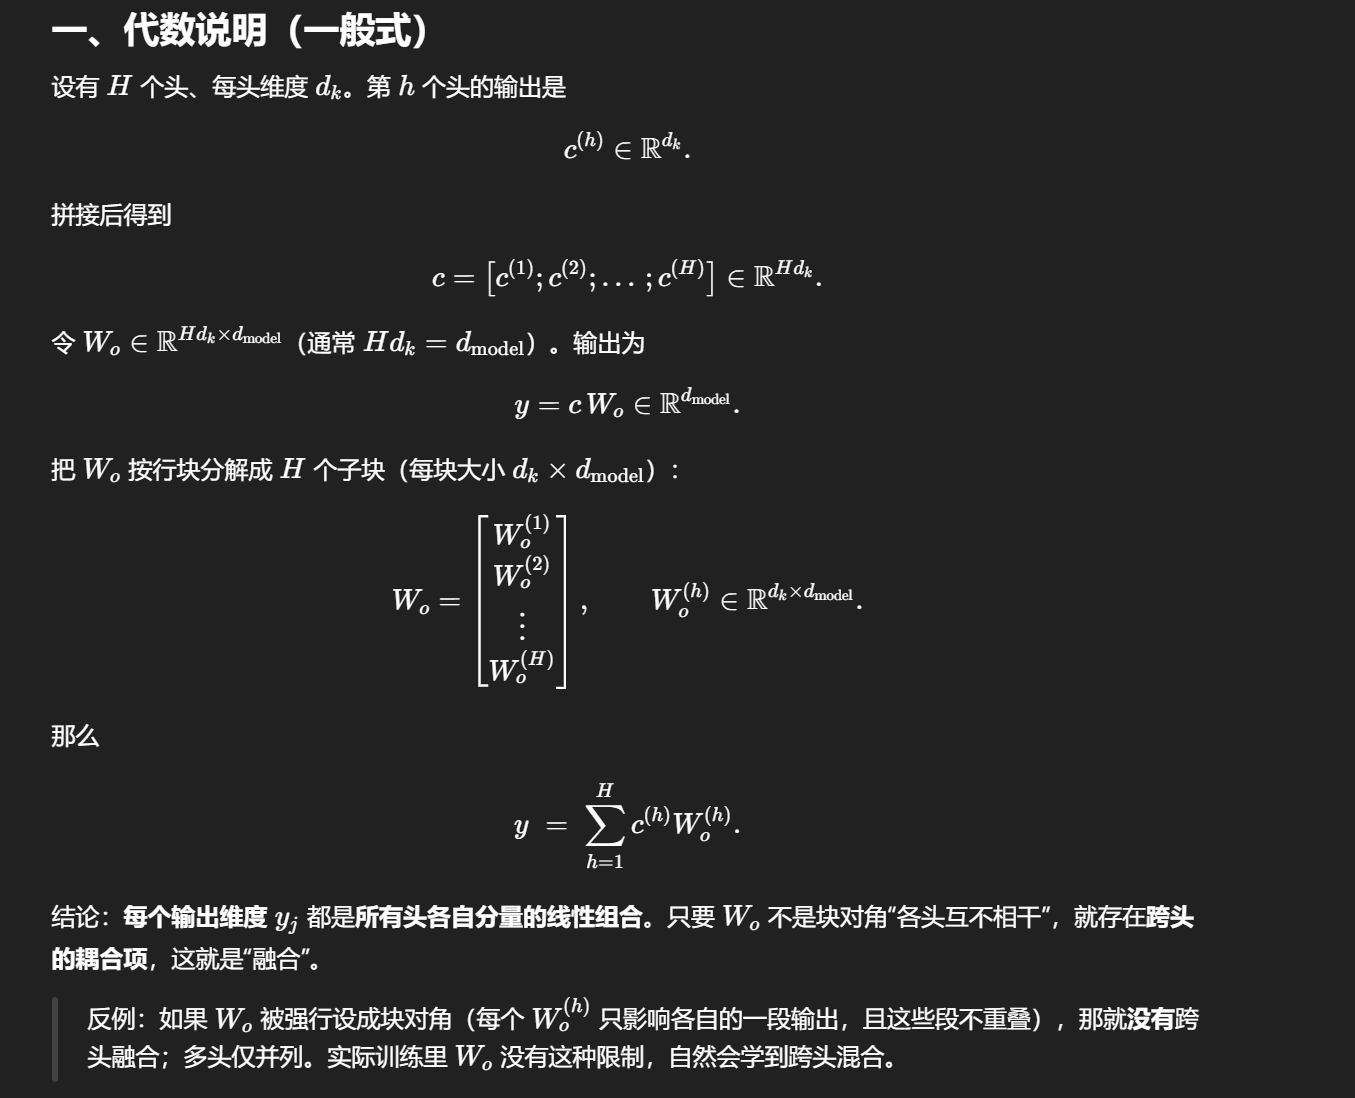

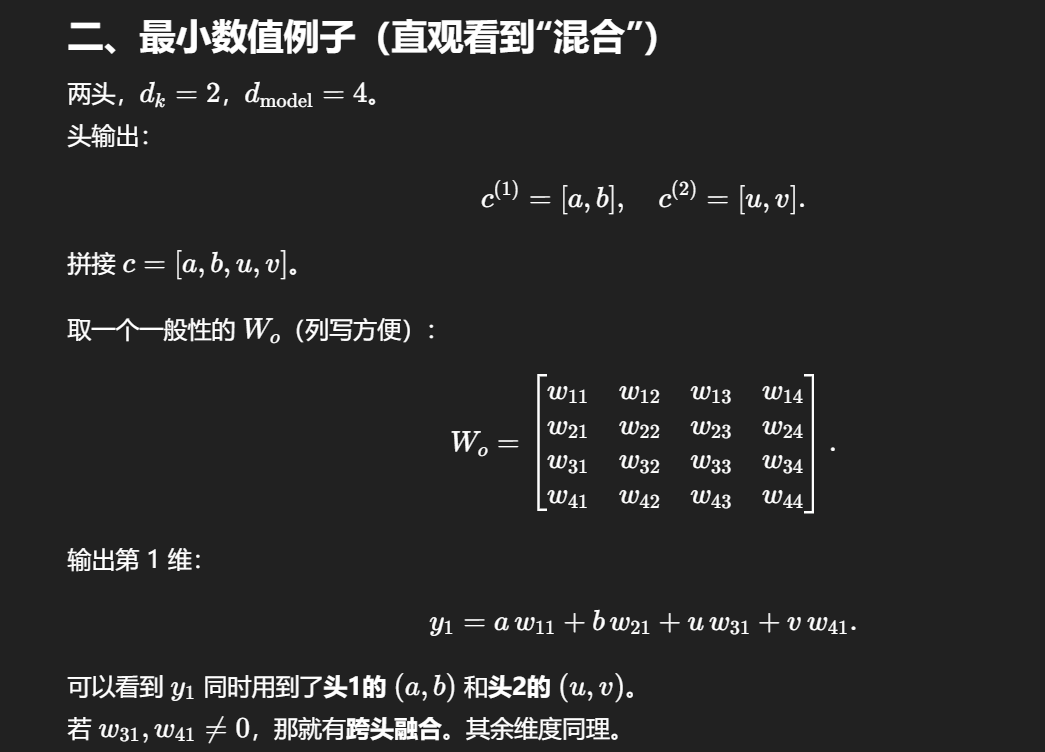

**Exercise 3.3 Initializing GPT-2 size attention modules**

Using the MultiHeadAttention class, initialize a multi-head attention module that
has the same number of attention heads as the smallest GPT-2 model (12 attention
heads). Also ensure that you use the respective input and output embedding sizes
similar to GPT-2 (768 dimensions). Note that the smallest GPT-2 model supports a
context length of 1,024 tokens.

In [135]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.encoding_for_model("gpt-4")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride) 
    dataloader = DataLoader(
                            dataset,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            drop_last=drop_last, 
                            num_workers=num_workers 
    )
    return dataloader

In [136]:
# 原始数据
with open("the-verdict.txt", "r") as f:
    raw_text = f.read()

In [142]:
# 建立词表，分词，转换为token_id
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=1, shuffle=False)
dataiter = iter(dataloader)
input_ids, target_ids = next(dataiter)

In [138]:
vocab_size = 50257
output_dim = 768

In [139]:
# 将每个token id转化为嵌入向量
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

In [143]:
token_vector = token_embedding_layer(input_ids)

In [144]:
token_vector.shape

torch.Size([8, 4, 768])

In [151]:
# 多头注意力机制
ma = MultiHeadAttention(768, 768, context_length=1024, dropout=0.0, num_heads=12)

In [153]:
# 转化为context vector
context_txt = ma(token_vector)

In [154]:
context_txt.shape

torch.Size([8, 4, 768])

In [155]:
context_txt[1]

tensor([[ 0.2276, -0.0853, -0.2489,  ...,  0.4727, -0.2900, -0.5981],
        [ 0.1181, -0.0289, -0.0753,  ...,  0.1761, -0.4066, -0.2672],
        [ 0.2835, -0.0123, -0.0851,  ...,  0.1309, -0.3219, -0.3513],
        [ 0.0723, -0.0893,  0.0013,  ...,  0.1595, -0.2998, -0.3098]],
       grad_fn=<SelectBackward0>)